# Entrega laboratorio 2

## Integrantes 

- Javier Steven Barrera Toro - 202214779
- Julian Santiago Rolon Toloza - 202215839

In [2]:
from pyomo.environ import ConcreteModel, RangeSet, \
    Param, Var, Binary, \
    Objective, maximize, Constraint, value, \
    NonNegativeIntegers, minimize, \
    NonNegativeReals

import numpy
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from typing import List

from pyomo.opt import SolverFactory

# Punto 1

El objetivo es transportar recursos esenciales a diferentes zonas de Zambia utilizando una flota de 3 aviones. 

## Conjuntos
- $F = F_1, F_2, F_3$ conjunto de los 3 aviones
- $R = R_1, \dots , R_5$ conjunto de los 5 recursos  

## Parámetros
- $W_i$ peso máximo que puede transportar el $i \in F$ avión
- $V_i$ volumen máximo que puede transportar el $i \in F$ avión
- $w_j$ peso del $j \in R$ recurso
- $v_j$ volumen del $j \in R$ recurso
- $p_j$ beneficio de llevar el $j \in R$ recurso

## Variables de decisión
- $X_{i,j}$ matriz de reales no negativos que indica cuanto se lleva del recurso $j \in R$ en el avión $i \in F$ en kilogramos.
- $Z_{i,j}$ matriz binaria que indica si el $i \in F$ avión llevan el $j \in R$ recurso. 

## Función objetivo
Se quiere maximizar el valor de los recursos que se llevan en la flota de aviones.
$$
\max \sum_{i \in F} \sum_{j \in R} X_{i,j} \times \frac{p_j}{m_j}
$$

## Restricciones
1. Cada uno de los aviones no puede llevar mas peso que su capacidad maxima.
$$
\sum_{j \in R} X_{i,j} \leq W_i, \forall i \in F
$$
2. Cada uno de los aviones no puede llevar mas volumen que su capacidad maxima.
$$
\sum_{j \in R} X_{i,j} \times v_j \leq V_i, \forall i \in F
$$
3. No se puede llevar una cantidad negativa de recursos.
$$
X_{i,j} \geq 0, \forall i \in F \,\,\, \forall j \in R
$$
4. No se pueden llevar mas recursos que los disponibles. Es decir, lo que se puede llevar en un avión no debe exceder la disponibilidad del recurso mismo
$$
\sum_{i \in F} X_{i,j} \leq w_j , \, \forall j \in R
$$
5. Los equipos medicos se tienen que llevar en unidades de 300 kg.
$$
X_{i,3} = 300 * Z_{i,3}, \forall i \in F 
$$
6. (Logistica 1) Las medicinas no pueden ir en el avión 1.
$$
X_{1,2} = 0
$$
7. (Logistica 2) El agua y los equipos medicos no pueden ir juntos en un avión para evitar contaminación cruzada. En este punto se puede optar por definir una variable auxiliar $Z$, que será una matriz binaria (0 y 1), de las dimensiones de $X$ tal que se almacena en la entrada $X_{i,j}$ si se lleva o no un recurso. De tal manera que se pueda realizar la restricción de manera más sencilla. 
$$
Z_{i,3} + Z_{i,4} \leq 1
$$

Al introducir esta variable auxiliar es necesario relacionarla con la variable objetivo. Por tanto, nacen dos restricciones mas: 1) Si $X_{i,j} > 0$, entonces $Z_{i,j} = 0$. 2) Si $X_{i,j} = 0$, entonces $Z_{i,j} = 0$.

## Tipo de problema 

In [3]:
from pyomo.environ import *

# Conjunto de aviones y recursos
F = [1, 2, 3]  # Aviones
R = [1, 2, 3, 4, 5]  # Recursos

# Parámetros
W = {1: 30000, 2: 40000, 3: 50000}  # Peso máximo por avión (kg)
V = {1: 25, 2: 30, 3: 35}  # Volumen máximo por avión (m³)
w = {1: 15000, 2: 5000, 3: 20000, 4: 18000, 5: 10000}  # Peso total disponible por recurso (kg)
v = {1: 8/15000, 2: 2/5000, 3: 10/20000, 4: 12/18000, 5: 6/10000}  # Volumen por kg
p = {1: 50, 2: 100, 3: 120, 4: 60, 5: 40}  # Beneficio por recurso

# Modelo
model = ConcreteModel()

# Variables de decisión
model.X = Var(F, R, domain=NonNegativeReals)  # Cantidad de recurso transportado (kg)
model.Z = Var(F, R, domain=Binary)  # Indica si un recurso es transportado

# Función objetivo: maximizar beneficio
model.obj = Objective(expr=sum(p[j] * model.X[i, j] for i in F for j in R), sense=maximize)

# Restricciones
# Capacidad de peso de cada avión
model.weight_constraint = ConstraintList()
for i in F:
    model.weight_constraint.add(sum(model.X[i, j] for j in R) <= W[i])

# Capacidad de volumen de cada avión
model.volume_constraint = ConstraintList()
for i in F:
    model.volume_constraint.add(sum(v[j] * model.X[i, j] for j in R) <= V[i])

# Disponibilidad de recursos
model.resource_constraint = ConstraintList()
for j in R:
    model.resource_constraint.add(sum(model.X[i, j] for i in F) <= w[j])

# Medicinas no pueden ir en el avión 1
model.medicine_constraint = Constraint(expr=model.X[1, 2] == 0)

# Equipos médicos indivisibles
model.medical_equipment_constraint = ConstraintList()
for i in F:
    model.medical_equipment_constraint.add(model.X[i, 3] == 300 * model.Z[i, 3])

# Incompatibilidad entre equipos médicos y agua potable
model.compatibility_constraint = ConstraintList()
for i in F:
    model.compatibility_constraint.add(model.Z[i, 3] + model.X[i, 4] <= 1)

# No negatividad ya está implícita en la declaración de variables

# Solver
solver = SolverFactory('glpk')
solver.solve(model)

# Resultados
beneficio_total = model.obj()
print(f'Beneficio total recolectado: {beneficio_total:.2f}')
for i in F:
    peso_total = sum(model.X[i, j].value for j in R if model.X[i, j].value > 0)
    volumen_total = sum(v[j] * model.X[i, j].value for j in R if model.X[i, j].value > 0)
    print(f'Avión {i} transporta {peso_total:.2f} kg con un volumen total de {volumen_total:.2f} m³')
    for j in R:
        if model.X[i, j].value > 0:
            print(f'    - {model.X[i, j].value:.2f} kg del recurso {j}')


Beneficio total recolectado: 1758000.00
Avión 1 transporta 25300.00 kg con un volumen total de 14.15 m³
    - 15000.00 kg del recurso 1
    - 300.00 kg del recurso 3
    - 10000.00 kg del recurso 5
Avión 2 transporta 5300.00 kg con un volumen total de 2.15 m³
    - 5000.00 kg del recurso 2
    - 300.00 kg del recurso 3
Avión 3 transporta 300.00 kg con un volumen total de 0.15 m³
    - 300.00 kg del recurso 3


# Punto 2

In [4]:
class TransportProblemSolver:
    """
    A class to solve the transport problem.
    ...
    Attributes
    ----------
    costs : List[List[float]]
        A matrix in which each entry represents the cost of going from a distribution
        city to a destination city.
    offer : List[int]
        An array with the availability of resources in each distribution city.
    demand : List[int]
        An array with the demand of resources in each destination city.
    """

    def __init__(self, costs: List[List[float]], offer: List[int], demand: List[int]):
        if len(costs) == 0:
            raise "Error: la matriz de costos no puede ser vacia"
        elif len(demand) != len(costs):
            raise "Error: cada j ciudad destino debe tener una fila en la matriz"
        elif len(offer) != len(costs[0]):
            raise "Error: cada i ciudad distribuidora debe tener una columna en la matriz"

        self.offer = offer
        self.costs = costs
        self.demand = demand

    def setup(self):
        model = ConcreteModel()

        # sets
        model.D = RangeSet(1, len(self.demand)) # destination
        model.O = RangeSet(1, len(self.offer)) # origin

        # params
        dict_ofert = {i+1: self.offer[i] for i in range(len(self.offer))}
        dict_demand = {i+1: self.demand[i] for i in range(len(self.demand))}
        dict_costs = {
            (i+1, j+1): self.costs[i][j]
            for j in range(len(self.costs[0])) for i in range(len(self.costs))
        }

        model.offer = Param(model.O, initialize=dict_ofert)
        model.demand = Param(model.D, initialize=dict_demand)
        model.costs = Param(model.D, model.O, initialize=dict_costs)
        
        # dec. variable
        model.X = Var(model.D, model.O, within=NonNegativeIntegers)

        # objective function
        def obj_function(model):
            return sum(model.X[i, j] * model.costs[i, j] for j in model.O for i in model.D)
        model.obj_function = Objective(rule=obj_function, sense=minimize)

        # constraints
        def offer_constr(model, j):
            return sum(model.X[i,j] for i in model.D) <= model.offer[j]
        model.offer_contr = Constraint(model.O, rule=offer_constr)

        def demand_constr(model, i):
            return sum(model.X[i,j] for j in model.O) >= model.demand[i]
        model.demand_constr = Constraint(model.D, rule=demand_constr)

        self.model = model

    def solve(self):
        solver = SolverFactory('glpk')
        solver.solve(self.model)

    def print_solution(self):
        for j in self.model.O:
            print(f"Desde {j} ciudad se ha sumistrado recursos hacia: ")
            ofert = 0
            for i in self.model.D:
                if self.model.X[i, j].value != 0:
                    ofert += self.model.X[i,j].value
                    resources = self.model.X[i,j].value
                    print(f"\t[->] destino {i} un total de {resources} recursos (min: {self.model.demand[i]})")
            print('\t---- STATS ----')
            print(f'\tused: {ofert}/{self.model.offer[j]} from distribution city\n')

In [5]:
offer = [550, 700]
costs = [
    [9999, 2.5],
    [2.5, 9999],
    [1.6, 2.0],
    [1.5, 1.0],
    [0.8, 1.0],
    [1.4, 0.8]
]
demand = [125, 175, 225, 250, 225, 200]

solver = TransportProblemSolver(costs, offer, demand)
solver.setup()
solver.solve()
solver.print_solution()

Desde 1 ciudad se ha sumistrado recursos hacia: 
	[->] destino 2 un total de 175.0 recursos (min: 175)
	[->] destino 3 un total de 225.0 recursos (min: 225)
	[->] destino 5 un total de 150.0 recursos (min: 225)
	---- STATS ----
	used: 550.0/550 from distribution city

Desde 2 ciudad se ha sumistrado recursos hacia: 
	[->] destino 1 un total de 125.0 recursos (min: 125)
	[->] destino 4 un total de 250.0 recursos (min: 250)
	[->] destino 5 un total de 75.0 recursos (min: 225)
	[->] destino 6 un total de 200.0 recursos (min: 200)
	---- STATS ----
	used: 650.0/700 from distribution city



# Punto 3

## Matriz de cobertura

In [25]:
def generate_coverage_matrix(position, n=8):
    """
    Generates a dictionary representing the coverage of a queen placed at a given position on an n x n chessboard.

    Args:
        position (tuple): The (row, column) position of the queen.
        n (int): The size of the chessboard (default is 8 for standard chess).

    Returns:
        dict: A dictionary with keys as (i, j) positions and values as 1 if covered, 0 otherwise.
    """
    i, j = position
    coverage = {}

    # Mark row and column
    for k in range(1, n + 1):
        coverage[(i, k)] = 1
        coverage[(k, j)] = 1

    # Mark diagonals
    for k in range(1, n + 1):
        if 1 <= i + k <= n and 1 <= j + k <= n:
            coverage[(i + k, j + k)] = 1
        if 1 <= i - k <= n and 1 <= j - k <= n:
            coverage[(i - k, j - k)] = 1
        if 1 <= i + k <= n and 1 <= j - k <= n:
            coverage[(i + k, j - k)] = 1
        if 1 <= i - k <= n and 1 <= j + k <= n:
            coverage[(i - k, j + k)] = 1

    # The queen's own position
    coverage[(i, j)] = 1

    for i in range(n):
        for j in range(n):
            if (i,j) not in coverage:
                coverage[(i,j)] = 0

    return coverage

# Ejemplo de uso
position = (1, 1)  # Reina en la fila 3, columna 4
coverage = generate_coverage_matrix(position)

print(coverage)

{(1, 1): 1, (1, 2): 1, (2, 1): 1, (1, 3): 1, (3, 1): 1, (1, 4): 1, (4, 1): 1, (1, 5): 1, (5, 1): 1, (1, 6): 1, (6, 1): 1, (1, 7): 1, (7, 1): 1, (1, 8): 1, (8, 1): 1, (2, 2): 1, (3, 3): 1, (4, 4): 1, (5, 5): 1, (6, 6): 1, (7, 7): 1, (8, 8): 1, (0, 0): 0, (0, 1): 0, (0, 2): 0, (0, 3): 0, (0, 4): 0, (0, 5): 0, (0, 6): 0, (0, 7): 0, (1, 0): 0, (2, 0): 0, (2, 3): 0, (2, 4): 0, (2, 5): 0, (2, 6): 0, (2, 7): 0, (3, 0): 0, (3, 2): 0, (3, 4): 0, (3, 5): 0, (3, 6): 0, (3, 7): 0, (4, 0): 0, (4, 2): 0, (4, 3): 0, (4, 5): 0, (4, 6): 0, (4, 7): 0, (5, 0): 0, (5, 2): 0, (5, 3): 0, (5, 4): 0, (5, 6): 0, (5, 7): 0, (6, 0): 0, (6, 2): 0, (6, 3): 0, (6, 4): 0, (6, 5): 0, (6, 7): 0, (7, 0): 0, (7, 2): 0, (7, 3): 0, (7, 4): 0, (7, 5): 0, (7, 6): 0}


## Modelo matematico

### Conjuntos
Se plantean los siguientes dos conjuntos.

- $F = \{1, 2, \dots, 8\}$ conjunto con las filas del tablero
- $C = \{1, 2, \dots, 8\}$ conjunto con las columnas del tablero

### Parámetros relevantes
En este caso el tamaño del tablero es un parámetro relevante ya que podemos definir este del tamaño que queramos $n \times m$. Sin embargo, para este caso se opta por tener un tablero de $8 \times 8$ para simplificar el problema. 

### Variable objetivo
Se define $X_{ij}$ como una matriz binaria de tamaño $8\times 8$ con $i \in F$ y $j \in C$. Esta matriz $X_{ij}$ será será 1 si hay una reina en esa posición y 0 de lo contrario.

### Función objetivo 
Se quiere minimizar el número de reinas que se ubican en el tablero de ajedrez. Por tanto,

$$
\min \sum_{i \in F} \sum_{j \in C} X_{ij}
$$

### Restricciones
- Cada casilla tiene que estar cubierta por lo menos por una reina.

$$
\sum_{k \in F} X_{k, j} + \sum_{k \in C} X_{i, k} + \sum_{k = 1}^{8} X_{i- k, j-k} + \sum_{k = 1}^{8} X_{i+ k, j+k} + \sum_{k = 1}^{8}X_{i- k, j+k} + \sum_{k = 1}^{8} X_{i+k, j-k} \geq 1 \,, \forall i \in F, j \in C \, | \, 1 \leq i \leq 8 \wedge 1 \leq j \leq 8
$$

## Tipo de problema
Este problema es de programación lineal entera, las restricciones y la función objetivo son combinaciones lineales de la variable de decisión. Además, todo se mueve en el dominio de los enteros positivos (0 y 1). 

## Modelo de Pyomo

In [3]:
# Definir el modelo
model = ConcreteModel()

# Conjuntos
n = 8  # Tamaño del tablero
model.F = RangeSet(1, n)
model.C = RangeSet(1, n)

# Variables de decisión
model.X = Var(model.F, model.C, within=Binary)  # 1 si hay una reina en (i, j)

# Función objetivo: minimizar el número de reinas
model.obj = Objective(expr=sum(model.X[i, j] for i in model.F for j in model.C), sense=minimize)

# Restricción de cobertura: cada casilla debe estar cubierta por al menos una reina
def cover_rule(model, i, j):
    return sum(model.X[k, j] for k in model.F) + \
           sum(model.X[i, k] for k in model.C) + \
           sum(model.X[i-k, j-k] for k in range(1, n) if 1 <= i-k <= n and 1 <= j-k <= n) + \
           sum(model.X[i+k, j+k] for k in range(1, n) if 1 <= i+k <= n and 1 <= j+k <= n) + \
           sum(model.X[i-k, j+k] for k in range(1, n) if 1 <= i-k <= n and 1 <= j+k <= n) + \
           sum(model.X[i+k, j-k] for k in range(1, n) if 1 <= i+k <= n and 1 <= j-k <= n) >= 1

model.cover_constraints = Constraint(model.F, model.C, rule=cover_rule)

# Resolver el modelo
solver = SolverFactory('glpk')
solver.solve(model)

{'Problem': [{'Name': 'unknown', 'Lower bound': 5.0, 'Upper bound': 5.0, 'Number of objectives': 1, 'Number of constraints': 64, 'Number of variables': 64, 'Number of nonzeros': 1520, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': '1031', 'Number of created subproblems': '1031'}}, 'Error rc': 0, 'Time': 0.9429399967193604}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

## Resolución y análisis

El siguiente bloque de código se encarga de realizar la presentación de los resultados. También se ejecuto cambiando la lista de reinas seleccionadas y se muestra que todo efectivamente se cubre, tal y como se observa en la siguiente imagen.

<center>
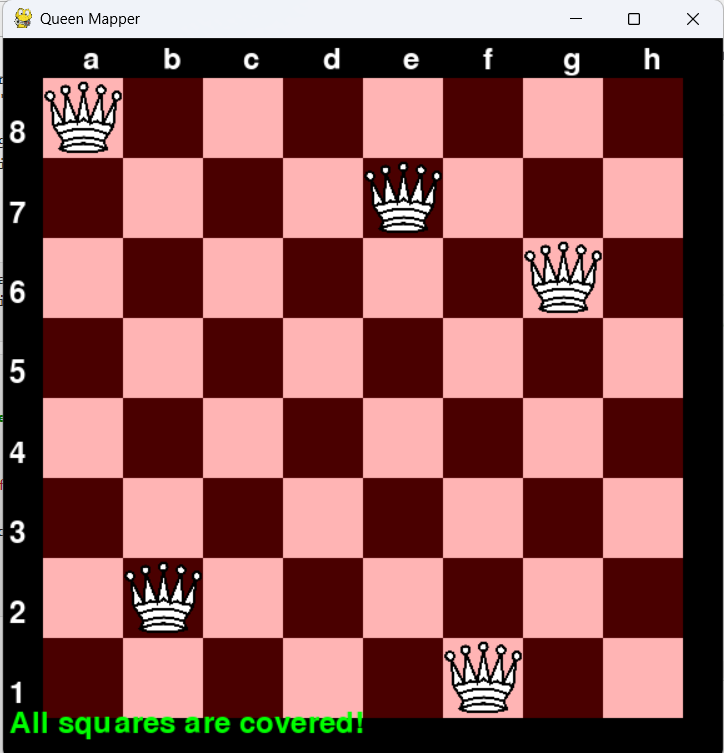
</center>

El resultado anterior muestra una solución válida al problema de cobertura mínima con reinas, donde solo cinco reinas han sido colocadas en posiciones para garantizar que todas las casillas del tablero estén cubiertas. La salida textual (el siguiente bloque de código que se ejecuta) confirma que la cobertura es completa, y la notación algebraica de las posiciones de las reinas coincide con la visualización. Esto sugiere que el modelo de optimización está funcionando correctamente y ha encontrado una solución óptima o cercana a la óptima en términos del número mínimo de reinas necesarias para este caso.

In [19]:
print("="*10 + " tablero " + "="*10)
for i in model.F:
    row = "".join("Q " if model.X[i, j].value == 1 else ". " for j in model.C)
    print(row)

mapper = {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h'}

l = [f"{mapper[j]}{9 - i}" for i in model.F for j in model.C if model.X[i,j].value == 1]
print()
print("="*10 + "selected queens" + "="*10)
print(l)

========== tablero ==========
Q . . . . . . . 
. . . . Q . . . 
. . . . . . Q . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. Q . . . . . . 
. . . . . Q . . 

==========selected queens==========
['a8', 'e7', 'g6', 'b2', 'f1']


In [18]:
!python ./queen_mapper.py

pygame 2.6.1 (SDL 2.28.4, Python 3.9.21)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Punto 4

# Punto 5